In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install a helper library for model summaries
!pip install torchinfo

# Import all the libraries we'll need
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models, datasets
from PIL import Image # For loading images
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # To convert text labels to numbers
from torchinfo import summary
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install a helper library for model summaries
!pip install torchinfo

# Import all the libraries we'll need
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models, datasets
from PIL import Image # For loading images
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
# --- 1. DEFINE YOUR PATHS (Same as before) ---
# This should work perfectly because of the shortcut you made
train_dir = '/content/drive/My Drive/sparsha_data/Dermnet/train'
test_dir = '/content/drive/My Drive/sparsha_data/Dermnet/test'

# --- 2. DEFINE TRANSFORMS (THIS IS OUR FIRST CHANGE) ---
IMAGE_SIZE = 380 # B4 was trained on 380x380 images

# Standard normalization (same as before)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transforms for training data (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Now resizes to 380x380
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    normalize
])

# Transforms for test data (NO augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Now resizes to 380x380
    transforms.ToTensor(),
    normalize
])

# --- 3. CREATE DATASET OBJECTS (Same as before) ---
try:
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

    print(f"Successfully loaded {len(train_dataset)} training images.")
    print(f"Successfully loaded {len(test_dataset)} testing images.")
    print(f"\nFound {len(train_dataset.classes)} classes:")
    print(train_dataset.classes)
except Exception as e:
    print(f"ERROR: Could not load images. Check your paths!")
    print(f"Your 'train_dir' path is: {train_dir}")
    print(f"Your 'test_dir' path is: {test_dir}")
    print(f"Error message: {e}")

Successfully loaded 15619 training images.
Successfully loaded 4002 testing images.

Found 23 classes:
['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral 

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=aeadb5f0c34ee64ff9b8bc8570dfeabb143a8e669f567ca8f58ad53646624b52
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Helper function to load and show an image
def load_image(image_path):
    img = cv2.imread(image_path)
    # This line is modified for B4:
    img = cv2.resize(img, (380, 380)) # Resize to 380x380
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR (OpenCV) to RGB (Matplotlib)
    return img

# Helper function to display the results (Side-by-Side Version)
def show_heatmap(original_img, heatmap):
    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(original_img / 255.0, heatmap, use_rgb=True)

    # Show the plot (modified to show two images)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

print("Helper functions for Grad-CAM (380x380, Side-by-Side) are ready.")

Helper functions for Grad-CAM (380x380, Side-by-Side) are ready.


In [ ]:
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Helper function to load and show an image
def load_image(image_path):
    img = cv2.imread(image_path)
    # This line is modified for B4:
    img = cv2.resize(img, (380, 380)) # Resize to 380x380
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR (OpenCV) to RGB (Matplotlib)
    return img

# Helper function to display the results (Side-by-Side Version)
def show_heatmap(original_img, heatmap):
    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(original_img / 255.0, heatmap, use_rgb=True)

    # Show the plot (two images)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

print("Helper functions for Grad-CAM (380x380, Side-by-Side) are ready.")

Helper functions for Grad-CAM (380x380, Side-by-Side) are ready.


In [ ]:
# --- 1. Define NUM_CLASSES (THE FIX) ---
# We get this from the train_dataset we loaded in Step 2
NUM_CLASSES = len(train_dataset.classes)
print(f"Found {NUM_CLASSES} classes.")

# --- 2. Re-create the model structure (B4 with Dropout) ---
print("Loading EfficientNet-B4 model structure...")
model = models.efficientnet_b4(weights=None) # Start with an un-trained model
num_ftrs = model.classifier[1].in_features

# This must match the model you trained
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),  # 40% Dropout
    nn.Linear(num_ftrs, NUM_CLASSES)  # Final layer
)

# --- 3. Load Your Best Checkpoint from Experiment 4 ---
# This is your new champion model!
CHECKPOINT_PATH = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_19.pt'
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))

# --- 4. Set model to evaluation mode ---
model.eval()

print(f"Model {CHECKPOINT_PATH} loaded successfully on CPU and set to eval mode.")

Found 23 classes.
Loading EfficientNet-B4 model structure...
Model /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_19.pt loaded successfully on CPU and set to eval mode.


In [ ]:
# --- 1. Set Image Path ---
# This is the path you just provided
IMAGE_PATH = '/content/drive/MyDrive/sparsha_data/Dermnet/test/Acne and Rosacea Photos/rosacea-1.jpg'

# --- 2. Load and Preprocess the Image ---
# Load the image using our new 380x380 OpenCV helper
original_img = load_image(IMAGE_PATH)

# Preprocess the image for the model (convert to tensor, normalize)
# This uses the 'test_transform' you defined in your original Step 2
# We use Image.fromarray because the transform expects a PIL Image
input_tensor = test_transform(Image.fromarray(original_img)).unsqueeze(0)

print(f"Loaded image: {IMAGE_PATH}")

Loaded image: /content/drive/MyDrive/sparsha_data/Dermnet/test/Acne and Rosacea Photos/rosacea-1.jpg


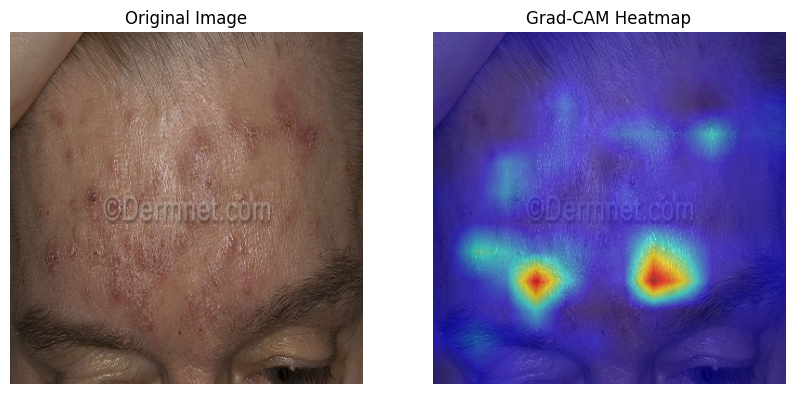

Model prediction (69.34% accurate): Acne and Rosacea Photos


In [ ]:
# --- 1. (THE FIX) Define class_names ---
# We get this from the train_dataset we loaded in Step 2
class_names = train_dataset.classes

# --- 2. Define the target layer to watch ---
# For EfficientNet-B4, this is the last "MBConv" block
target_layer = [model.features[-1]]

# --- 3. Initialize Grad-CAM ---
# We use the corrected version without 'use_cuda'
cam = GradCAM(model=model, target_layers=target_layer)

# --- 4. Get the Model's Prediction ---
# 'targets = None' will make it explain the winning class
targets = None

# --- 5. Generate the Heatmap ---
# This runs the model and gets the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# We only want the first (and only) heatmap
grayscale_cam = grayscale_cam[0, :]

# --- 6. Show the Result ---
# This uses the side-by-side helper function from your new Step 4
show_heatmap(original_img, grayscale_cam)

# --- 7. See what the model predicted ---
output = model(input_tensor)
_, pred_index = torch.max(output, 1)
predicted_class = class_names[pred_index.item()] # This line will work now
print(f"Model prediction (69.34% accurate): {predicted_class}")

In [ ]:
# --- 1. Define NUM_CLASSES (THE FIX) ---
# We get this from the train_dataset we loaded in Step 2
NUM_CLASSES = len(train_dataset.classes)
print(f"Found {NUM_CLASSES} classes.")

# --- 2. Re-create the model structure (B4 with Dropout) ---
print("Loading EfficientNet-B4 model structure...")
model = models.efficientnet_b4(weights=None) # Start with an un-trained model
num_ftrs = model.classifier[1].in_features

# This must match the model you trained
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),  # 40% Dropout
    nn.Linear(num_ftrs, NUM_CLASSES)  # Final layer
)

# --- 3. Load Your Best Checkpoint from Experiment 4 ---
# This is your new champion model!
CHECKPOINT_PATH = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_19.pt'
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))

# --- 4. Set model to evaluation mode ---
model.eval()

print(f"Model {CHECKPOINT_PATH} loaded successfully on CPU and set to eval mode.")

Found 23 classes.
Loading EfficientNet-B4 model structure...
Model /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_19.pt loaded successfully on CPU and set to eval mode.


In [ ]:
# --- 1. Set Image Path (!! CHANGE THIS !!) ---
IMAGE_PATH = '/content/drive/My Drive/sparsha_data/Dermnet/test/Melanoma Skin Cancer Nevi and Moles/melanoma_10100.jpg' # <-- PASTE YOUR COPIED PATH HERE

# --- 2. Load and Preprocess the Image ---
# Load the image using our new 380x380 OpenCV helper
original_img = load_image(IMAGE_PATH)

# Preprocess the image for the model (convert to tensor, normalize)
# This uses the 'test_transform' you defined in your original Step 2
# We use Image.fromarray because the transform expects a PIL Image
input_tensor = test_transform(Image.fromarray(original_img)).unsqueeze(0)

print(f"Loaded image: {IMAGE_PATH}")

In [ ]:
from torch.utils.data import WeightedRandomSampler

# --- 1. Get Class Counts and Weights ---
labels = train_dataset.targets
class_counts = torch.tensor([labels.count(i) for i in range(len(train_dataset.classes))])
print(f"Original class counts: {class_counts}")
class_weights = 1.0 / class_counts.float()

# --- 2. Create Sample Weights for every single image ---
sample_weights = torch.tensor([class_weights[label] for label in labels])

# --- 3. Create the WeightedRandomSampler ---
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# --- 4. Create DataLoaders (THE FIX) ---
BATCH_SIZE = 8  # <-- This is the fix for the memory error
print(f"Using BATCH_SIZE = {BATCH_SIZE} to save memory. This will be very slow.")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# --- 5. Define Class Names and Number ---
class_names = train_dataset.classes
NUM_CLASSES = len(class_names)

print(f"\nCreated train_loader with {len(train_loader)} batches (using weighted sampler).")
print(f"Created test_loader with {len(test_loader)} batches.")
print(f"Total classes to predict: {NUM_CLASSES}")

Original class counts: tensor([ 840, 1150,  489,  449,  288, 1251,  404,  239,  405,  568,  420,  463,
        1040,  260, 1405,  431, 1383,  622, 1316,  212,  482,  416, 1086])
Using BATCH_SIZE = 8 to save memory. This will be very slow.

Created train_loader with 1953 batches (using weighted sampler).
Created test_loader with 501 batches.
Total classes to predict: 23


In [ ]:
# --- 1. Set Image Path ---
# This is the path you just provided
IMAGE_PATH = '/content/drive/MyDrive/sparsha_data/Dermnet/test/Acne and Rosacea Photos/rosacea-1.jpg'

# --- 2. Load and Preprocess the Image ---
# Load the image using our new 380x380 OpenCV helper
original_img = load_image(IMAGE_PATH)

# Preprocess the image for the model (convert to tensor, normalize)
# This uses the 'test_transform' you defined in your original Step 2
# We use Image.fromarray because the transform expects a PIL Image
input_tensor = test_transform(Image.fromarray(original_img)).unsqueeze(0)

print(f"Loaded image: {IMAGE_PATH}")

Loaded image: /content/drive/MyDrive/sparsha_data/Dermnet/test/Acne and Rosacea Photos/rosacea-1.jpg


Helper functions for Grad-CAM (380x380, Side-by-Side) are ready.


In [ ]:
# --- 1. Load the Pre-trained Model (THE BIG CHANGE) ---
# We are now loading 'efficientnet_b4'
print("Loading EfficientNet-B4 model...")
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)

# --- 2. Modify the Final Classifier (with Dropout) ---
# The 'in_features' number will be different for B4
num_ftrs = model.classifier[1].in_features

# We'll use the same Dropout strategy
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),  # 40% Dropout
    nn.Linear(num_ftrs, NUM_CLASSES)  # Final layer
)

# --- 3. Move Model to GPU ---
model = model.to(device)

# --- 4. Print a Summary ---
print(f"--- Model Summary (EfficientNet-B4 with Dropout) ---")
print(f"New classifier:\n{model.classifier}")

# We'll adjust the summary input size to our new 380x380 images
# We also use our new BATCH_SIZE of 8
summary(model, input_size=(BATCH_SIZE, 3, 380, 380))

Loading EfficientNet-B4 model...
--- Model Summary (EfficientNet-B4 with Dropout) ---
New classifier:
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=23, bias=True)
)


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [8, 23]                   --
├─Sequential: 1-1                                       [8, 1792, 12, 12]         --
│    └─Conv2dNormActivation: 2-1                        [8, 48, 190, 190]         --
│    │    └─Conv2d: 3-1                                 [8, 48, 190, 190]         1,296
│    │    └─BatchNorm2d: 3-2                            [8, 48, 190, 190]         96
│    │    └─SiLU: 3-3                                   [8, 48, 190, 190]         --
│    └─Sequential: 2-2                                  [8, 24, 190, 190]         --
│    │    └─MBConv: 3-4                                 [8, 24, 190, 190]         2,940
│    │    └─MBConv: 3-5                                 [8, 24, 190, 190]         1,206
│    └─Sequential: 2-3                                  [8, 32, 95, 95]           --
│    │    └─MBConv: 3-6                            

In [ ]:
# --- LOAD YOUR SAVED PROGRESS ---

# This path points to your last completed epoch
LOAD_CHECKPOINT_PATH = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_2.pt'

# Load the weights into your model
model.load_state_dict(torch.load(LOAD_CHECKPOINT_PATH))
model = model.to(device) # Move it to the GPU again

print(f"Successfully loaded weights from: {LOAD_CHECKPOINT_PATH}")
print("Ready to resume training from Epoch 3.")

Successfully loaded weights from: /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_2.pt
Ready to resume training from Epoch 3.


In [ ]:
# --- 1. Define Optimizer and Loss Function ---
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 2. Set Number of Epochs and Checkpoint Path ---
NUM_EPOCHS = 20 # We'll run for 20 epochs
checkpoint_dir = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/'
os.makedirs(checkpoint_dir, exist_ok=True)

print("--- RESUMING Experiment 4 (EfficientNet-B4) ---")
print(f"Using BATCH_SIZE = {BATCH_SIZE} to save memory.")
print(f"New models will be saved to: {checkpoint_dir}")

# --- 3. The Training Loop (MODIFIED) ---

# THIS IS THE KEY CHANGE: We start from epoch 2
for epoch in range(2, NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    # THIS IS THE CORRECTED LINE:
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects.double() / len(test_dataset)

    scheduler.step()

    # --- PRINT EPOCH RESULTS ---
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS} | Time: {time.time() - epoch_start_time:.0f}s")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_epoch_loss:.4f}   | Val Acc: {val_epoch_acc:.4f}")

    # --- SAVE CHECKPOINT ---
    checkpoint_path = os.path.join(checkpoint_dir, f"sparsha_exp4_B4_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"  [Checkpoint saved to: {checkpoint_path}]")

print("\n--- Finished Experiment 4 (B4) ---")

--- RESUMING Experiment 4 (EfficientNet-B4) ---
Using BATCH_SIZE = 8 to save memory.
New models will be saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/

Epoch 3/20 | Time: 1702s
  Train Loss: 0.9877 | Train Acc: 0.7065
  Val Loss: 1.8916   | Val Acc: 0.5260
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_3.pt]

Epoch 4/20 | Time: 739s
  Train Loss: 0.8513 | Train Acc: 0.7483
  Val Loss: 1.8192   | Val Acc: 0.5487
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_4.pt]

Epoch 5/20 | Time: 696s
  Train Loss: 0.7499 | Train Acc: 0.7734
  Val Loss: 1.9716   | Val Acc: 0.5640
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp5_B4/sparsha_exp4_B4_epoch_5.pt]

Epoch 6/20 | Time: 682s
  Train Loss: 0.6710 | Train Acc: 0.7986
  Val Loss: 1.9140   | Val Acc: 0.5495
  [Checkpoint saved to: /content/drive/My Drive/sparsha_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install a helper library for model summaries
!pip install torchinfo

# Import all the libraries we'll need
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models, datasets
from PIL import Image # For loading images
from sklearn.model_selection import train_test_split # <-- THIS LINE IS NOW FIXED
from sklearn.preprocessing import LabelEncoder # To convert text labels to numbers
from torchinfo import summary
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cpu


In [ ]:
# --- 1. DEFINE YOUR PATHS (Same as before) ---
train_dir = '/content/drive/My Drive/sparsha_data/Dermnet/train'
test_dir = '/content/drive/My Drive/sparsha_data/Dermnet/test'

# --- 2. DEFINE TRANSFORMS (THIS IS OUR FIRST CHANGE) ---
IMAGE_SIZE = 300 # B3 works best with 300x300 images

# Standard normalization (same as before)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transforms for training data (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Now resizes to 300x300
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    normalize
])

# Transforms for test data (NO augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Now resizes to 300x300
    transforms.ToTensor(),
    normalize
])

# --- 3. CREATE DATASET OBJECTS (Same as before) ---
try:
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

    print(f"Successfully loaded {len(train_dataset)} training images.")
    print(f"Successfully loaded {len(test_dataset)} testing images.")
    print(f"\nFound {len(train_dataset.classes)} classes:")
    print(train_dataset.classes)
except Exception as e:
    print(f"ERROR: Could not load images. Check your paths!")
    print(f"Your 'train_dir' path is: {train_dir}")
    print(f"Your 'test_dir' path is: {test_dir}")
    print(f"Error message: {e}")

Successfully loaded 15619 training images.
Successfully loaded 4002 testing images.

Found 23 classes:
['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral 

In [ ]:
from torch.utils.data import WeightedRandomSampler

# --- 1. Get Class Counts and Weights ---
labels = train_dataset.targets
class_counts = torch.tensor([labels.count(i) for i in range(len(train_dataset.classes))])
print(f"Original class counts: {class_counts}")
class_weights = 1.0 / class_counts.float()

# --- 2. Create Sample Weights for every single image ---
sample_weights = torch.tensor([class_weights[label] for label in labels])

# --- 3. Create the WeightedRandomSampler ---
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# --- 4. Create DataLoaders ---
BATCH_SIZE = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# --- 5. Define Class Names and Number ---
class_names = train_dataset.classes
NUM_CLASSES = len(class_names)

print(f"\nCreated train_loader with {len(train_loader)} batches (using weighted sampler).")
print(f"Created test_loader with {len(test_loader)} batches.")
print(f"Total classes to predict: {NUM_CLASSES}")

Original class counts: tensor([ 840, 1150,  489,  449,  288, 1251,  404,  239,  405,  568,  420,  463,
        1040,  260, 1405,  431, 1383,  622, 1316,  212,  482,  416, 1086])

Created train_loader with 489 batches (using weighted sampler).
Created test_loader with 126 batches.
Total classes to predict: 23


In [ ]:
# --- 1. Load the Pre-trained Model (THE BIG CHANGE) ---
# We are now loading 'efficientnet_b3' instead of 'b0'
print("Loading EfficientNet-B3 model...")
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# --- 2. Modify the Final Classifier (with Dropout) ---
# The 'in_features' number will be different for B3, so we get it from the model
num_ftrs = model.classifier[1].in_features

# We'll use the same Dropout strategy that worked well
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),  # 40% Dropout
    nn.Linear(num_ftrs, NUM_CLASSES)  # Final layer
)

# --- 3. Move Model to GPU ---
model = model.to(device)

# --- 4. Print a Summary ---
print(f"--- Model Summary (EfficientNet-B3 with Dropout) ---")
print(f"New classifier:\n{model.classifier}")

# We'll adjust the summary input size to our new 300x300 images
summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Loading EfficientNet-B3 model...
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 184MB/s]


--- Model Summary (EfficientNet-B3 with Dropout) ---
New classifier:
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1536, out_features=23, bias=True)
)


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 23]                  --
├─Sequential: 1-1                                       [32, 1536, 10, 10]        --
│    └─Conv2dNormActivation: 2-1                        [32, 40, 150, 150]        --
│    │    └─Conv2d: 3-1                                 [32, 40, 150, 150]        1,080
│    │    └─BatchNorm2d: 3-2                            [32, 40, 150, 150]        80
│    │    └─SiLU: 3-3                                   [32, 40, 150, 150]        --
│    └─Sequential: 2-2                                  [32, 24, 150, 150]        --
│    │    └─MBConv: 3-4                                 [32, 24, 150, 150]        2,298
│    │    └─MBConv: 3-5                                 [32, 24, 150, 150]        1,206
│    └─Sequential: 2-3                                  [32, 32, 75, 75]          --
│    │    └─MBConv: 3-6                            

In [ ]:
# --- 1. Define Optimizer and Loss Function ---
# We'll use the same successful settings from Experiment 2
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 2. Set Number of Epochs and NEW Checkpoint Path ---
NUM_EPOCHS = 20 # We'll run for 20 epochs

# THIS IS THE 3RD KEY CHANGE: A new folder for this new model
checkpoint_dir = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp3/'
os.makedirs(checkpoint_dir, exist_ok=True) # Create the folder if it doesn't exist

print("--- Starting Experiment 3 (EfficientNet-B3) ---")
print(f"New models will be saved to: {checkpoint_dir}")

# --- 3. The Training Loop ---
# (This code is the same as before)

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- TRAINING PHASE ---
    model.train() # Set model to training mode (activates Dropout)
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # --- Forward pass ---
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # --- Backward pass + optimize ---
        loss.backward()
        optimizer.step()

        # --- Statistics ---
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode (deactivates Dropout)
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects.double() / len(test_dataset)

    scheduler.step()

    # --- PRINT EPOCH RESULTS ---
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS} | Time: {time.time() - epoch_start_time:.0f}s")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_epoch_loss:.4f}   | Val Acc: {val_epoch_acc:.4f}")

    # --- SAVE CHECKPOINT ---
    checkpoint_path = os.path.join(checkpoint_dir, f"sparsha_exp3_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"  [Checkpoint saved to: {checkpoint_path}]")

print("\n--- Finished Experiment 3 ---")

In [ ]:
# --- 1. DEFINE YOUR PATHS (CHANGE THESE!) ---
# Point these to your Dermnet 'train' and 'test' folders
train_dir = '/content/drive/My Drive/sparsha_data/Dermnet/train'
test_dir = '/content/drive/My Drive/sparsha_data/Dermnet/test'

# --- 2. DEFINE TRANSFORMS ---
IMAGE_SIZE = 224 # EfficientNet-B0 uses 224x224 images

# Standard normalization for models trained on ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transforms for training data (with data augmentation)
# This is critical for getting high accuracy!
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomRotation(10),     # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # Randomly change colors
    transforms.ToTensor(),             # Convert image to a PyTorch tensor
    normalize                          # Normalize the tensor
])

# Transforms for validation/test data (NO augmentation)
# We only want to resize, convert to tensor, and normalize
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize
])

# --- 3. CREATE DATASET OBJECTS ---
# ImageFolder is a magic function that finds all subfolders (e.g., 'Acne', 'Eczema')
# and automatically labels the images inside them.
try:
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

    print(f"Successfully loaded {len(train_dataset)} training images.")
    print(f"Successfully loaded {len(test_dataset)} testing images.")
    print(f"\nFound {len(train_dataset.classes)} classes:")
    print(train_dataset.classes)
except Exception as e:
    print(f"ERROR: Could not load images. Check your paths!")
    print(f"Your 'train_dir' path is: {train_dir}")
    print(f"Your 'test_dir' path is: {test_dir}")
    print(f"Error message: {e}")

Successfully loaded 15619 training images.
Successfully loaded 4002 testing images.

Found 23 classes:
['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral 

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=65a00ce974725aeab732c7d83c88c2f5da812fe72d2dacdefaa893faee6440af
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Helper function to load and show an image
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224)) # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR (OpenCV) to RGB (Matplotlib)
    return img

# Helper function to display the results
def show_heatmap(original_img, heatmap):
    # Overlay the heatmap on the original image
    # 'original_img' must be 0-1, 'heatmap' is 0-1
    visualization = show_cam_on_image(original_img / 255.0, heatmap, use_rgb=True)

    # Show the plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.show()

print("Helper functions for Grad-CAM are ready.")

Helper functions for Grad-CAM are ready.


In [ ]:
# --- 1. Define NUM_CLASSES (THE FIX) ---
# We get this from the train_dataset we loaded in Step 2
NUM_CLASSES = len(train_dataset.classes)
print(f"Found {NUM_CLASSES} classes.")

# --- 2. Re-create the model structure from Experiment 1 ---
model = models.efficientnet_b0(weights=None) # Start with an un-trained model
num_ftrs = model.classifier[1].in_features

# This is the classifier from your FIRST experiment (no dropout)
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

# --- 3. Load your saved weights ---
# This path points to your best model from the first 20-epoch run
MODEL_PATH = '/content/drive/My Drive/sparsha_data/model_checkpoints/sparsha_epoch_18.pt'

# We use map_location=torch.device('cpu') to load the model onto the CPU
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

# --- 4. Set model to evaluation mode ---
model.eval()

print(f"Model {MODEL_PATH} loaded successfully on CPU and set to eval mode.")

Found 23 classes.
Model /content/drive/My Drive/sparsha_data/model_checkpoints/sparsha_epoch_18.pt loaded successfully on CPU and set to eval mode.


In [ ]:
# --- 1. Set Image Path (!! THIS IS THE ONLY LINE TO EDIT !!) ---
IMAGE_PATH = '/content/drive/MyDrive/sparsha_data/Dermnet/test/Acne and Rosacea Photos/rosacea-1.jpg' # <-- PASTE YOUR COPIED PATH HERE

# --- 2. Load and Preprocess the Image ---
original_img = load_image(IMAGE_PATH)
input_tensor = test_transform(Image.fromarray(original_img)).unsqueeze(0)

# --- 3. DO NOT EDIT THIS LINE ---
print(f"Loaded image: {IMAGE_PATH}")

Loaded image: /content/drive/MyDrive/sparsha_data/Dermnet/test/Acne and Rosacea Photos/rosacea-1.jpg


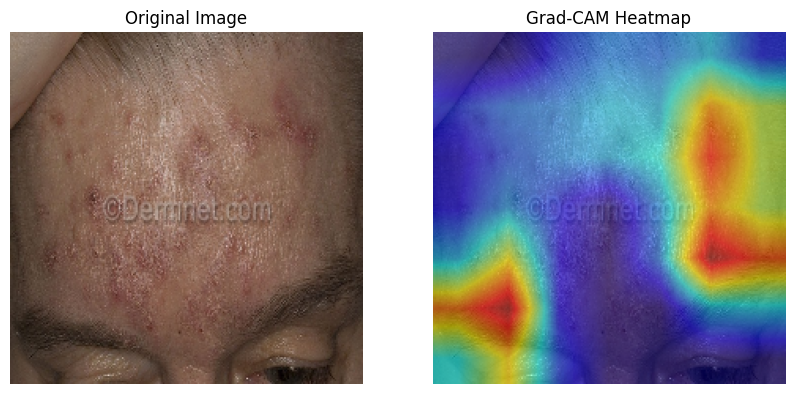

Model prediction: Acne and Rosacea Photos


In [ ]:
# --- 1. (THE FIX) Define class_names ---
class_names = train_dataset.classes

# --- 2. Define the target layer to watch ---
# For EfficientNet, this is the last "MBConv" block
target_layer = [model.features[-1]]

# --- 3. Initialize Grad-CAM ---
cam = GradCAM(model=model, target_layers=target_layer)

# --- 4. Get the Model's Prediction ---
targets = None

# --- 5. Generate the Heatmap ---
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# --- 6. Show the Result ---
show_heatmap(original_img, grayscale_cam)

# --- 7. See what the model predicted ---
output = model(input_tensor)
_, pred_index = torch.max(output, 1)
predicted_class = class_names[pred_index.item()] # This line will work now
print(f"Model prediction: {predicted_class}")

In [ ]:
from torch.utils.data import WeightedRandomSampler

# --- 1. Get Class Counts and Weights ---
# Get the list of all labels in the training dataset
labels = train_dataset.targets

# Count occurrences of each class
class_counts = torch.tensor([labels.count(i) for i in range(len(train_dataset.classes))])
print(f"Original class counts: {class_counts}")

# Calculate weights: weight = 1.0 / (num_samples_in_class)
class_weights = 1.0 / class_counts.float()

# --- 2. Create Sample Weights for every single image ---
# sample_weights will be a list [weight_for_img_1, weight_for_img_2, ...]
sample_weights = torch.tensor([class_weights[label] for label in labels])

# --- 3. Create the WeightedRandomSampler ---
# This sampler will now draw images based on their sample_weights
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# --- 4. Create DataLoaders ---
BATCH_SIZE = 32

# The train_loader uses the 'sampler' and MUST have shuffle=False
# The sampler handles the random shuffling based on weights
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2 # num_workers speeds up data loading
)

# The test_loader doesn't need a sampler
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No shuffling needed for testing
    num_workers=2
)

# --- 5. Define Class Names and Number ---
# We'll need these for the model
class_names = train_dataset.classes
NUM_CLASSES = len(class_names)

print(f"\nCreated train_loader with {len(train_loader)} batches (using weighted sampler).")
print(f"Created test_loader with {len(test_loader)} batches.")
print(f"Total classes to predict: {NUM_CLASSES}")

Original class counts: tensor([ 840, 1150,  489,  449,  288, 1251,  404,  239,  405,  568,  420,  463,
        1040,  260, 1405,  431, 1383,  622, 1316,  212,  482,  416, 1086])

Created train_loader with 489 batches (using weighted sampler).
Created test_loader with 126 batches.
Total classes to predict: 23


In [ ]:
# --- 1. Load the Pre-trained Model ---
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# --- 2. Modify the Final Classifier (with Dropout) ---
num_ftrs = model.classifier[1].in_features

# THIS IS THE KEY CHANGE:
# Instead of just one layer, we create a small sequence.
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),  # <-- ADDED: Randomly drops 40% of connections
    nn.Linear(num_ftrs, NUM_CLASSES)  # <-- The final layer
)

# --- 3. Move Model to GPU ---
model = model.to(device)

# --- 4. Print a Summary ---
print(f"--- Model Summary (with Dropout added) ---")
print(f"New classifier:\n{model.classifier}")
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s]


--- Model Summary (with Dropout added) ---
New classifier:
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=23, bias=True)
)


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 23]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [ ]:
# --- 1. Define Optimizer and Loss Function ---

# THIS IS THE 2ND KEY CHANGE: Added 'weight_decay'
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 2. Set Number of Epochs and NEW Checkpoint Path ---
NUM_EPOCHS = 20 # We'll run for 20 epochs again

# THIS IS THE 3RD KEY CHANGE: A new folder for this experiment
checkpoint_dir = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp2/'
os.makedirs(checkpoint_dir, exist_ok=True) # Create the folder if it doesn't exist

print("--- Starting Experiment 2 (with Dropout and Weight Decay) ---")
print(f"New models will be saved to: {checkpoint_dir}")

# --- 3. The Training Loop ---
# (This code is the same as before)

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- TRAINING PHASE ---
    model.train() # Set model to training mode (activates Dropout)
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # --- Forward pass ---
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # --- Backward pass + optimize ---
        loss.backward()
        optimizer.step()

        # --- Statistics ---
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode (deactivates Dropout)
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects.double() / len(test_dataset)

    scheduler.step()

    # --- PRINT EPOCH RESULTS ---
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS} | Time: {time.time() - epoch_start_time:.0f}s")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_epoch_loss:.4f}   | Val Acc: {val_epoch_acc:.4f}")

    # --- SAVE CHECKPOINT ---
    checkpoint_path = os.path.join(checkpoint_dir, f"sparsha_exp2_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"  [Checkpoint saved to: {checkpoint_path}]")

print("\n--- Finished Experiment 2 ---")

--- Starting Experiment 2 (with Dropout and Weight Decay) ---
New models will be saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp2/

Epoch 1/20 | Time: 2555s
  Train Loss: 2.2466 | Train Acc: 0.3466
  Val Loss: 2.1775   | Val Acc: 0.3671
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp2/sparsha_exp2_epoch_1.pt]

Epoch 2/20 | Time: 752s
  Train Loss: 1.7257 | Train Acc: 0.4988
  Val Loss: 1.9955   | Val Acc: 0.4285
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp2/sparsha_exp2_epoch_2.pt]

Epoch 3/20 | Time: 437s
  Train Loss: 1.4597 | Train Acc: 0.5731
  Val Loss: 1.9719   | Val Acc: 0.4478
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp2/sparsha_exp2_epoch_3.pt]

Epoch 4/20 | Time: 324s
  Train Loss: 1.2432 | Train Acc: 0.6296
  Val Loss: 1.9156   | Val Acc: 0.4680
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints_exp2/sparsha_exp2_epo

In [ ]:
# --- 1. Load the Pre-trained Model ---
# We are using efficientnet_b0 and specifying the 'weights' to get the
# version pre-trained on ImageNet.
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# --- 2. Modify the Final Classifier ---
# Let's look at the original classifier
print(f"Original classifier: {model.classifier}")

# Get the number of "in_features" from the original classifier
# This is the number of inputs to the final layer
num_ftrs = model.classifier[1].in_features

# Replace the classifier with a new, single Linear layer
# It will take 'num_ftrs' as input and output 'NUM_CLASSES' (23)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),  # Add a 40% Dropout layer
    nn.Linear(num_ftrs, NUM_CLASSES)  # Add the final layer
)

# --- 3. Move Model to GPU ---
model = model.to(device)

# --- 4. Print a Summary (Optional but helpful) ---
# This will show us the model architecture and confirm our change
print("\n--- Model Summary (after modification) ---")
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]


Original classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

--- Model Summary (after modification) ---


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 23]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          6,004
│    │    └─MBConv: 3-6                              

In [ ]:
# --- 1. Define Optimizer and Loss Function ---

# We'll use AdamW, a modern and effective optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

# CrossEntropyLoss is the standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# (Optional) A learning rate scheduler can help training
# This will gradually decrease the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# --- 2. Set Number of Epochs and Checkpoint Path ---
NUM_EPOCHS = 20 # Let's start with 20 epochs. You can always run for more later.

# This is where your models will be saved!
# Make sure your 'sparsha_data' folder exists
checkpoint_dir = '/content/drive/My Drive/sparsha_data/model_checkpoints_exp2/'
os.makedirs(checkpoint_dir, exist_ok=True) # Create the folder if it doesn't exist

print("--- Starting Training ---")
print(f"Models will be saved to: {checkpoint_dir}")

# --- 3. The Training Loop ---

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- TRAINING PHASE ---
    model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Loop over batches of data from the train_loader
    for inputs, labels in train_loader:
        # Move inputs and labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients (clear old calculations)
        optimizer.zero_grad()

        # --- Forward pass ---
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1) # Get the index of the highest score (our prediction)

        # --- Backward pass + optimize ---
        loss.backward()  # Calculate gradients
        optimizer.step() # Update model weights

        # --- Statistics ---
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    val_corrects = 0

    # We don't need to calculate gradients for validation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_corrects.double() / len(test_dataset)

    # Step the learning rate scheduler
    scheduler.step()

    # --- PRINT EPOCH RESULTS ---
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS} | Time: {time.time() - epoch_start_time:.0f}s")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    print(f"  Val Loss: {val_epoch_loss:.4f}   | Val Acc: {val_epoch_acc:.4f}")

    # --- SAVE CHECKPOINT ---
    checkpoint_path = os.path.join(checkpoint_dir, f"sparsha_epoch_{epoch+1}.pt")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"  [Checkpoint saved to: {checkpoint_path}]")

print("\n--- Finished Training ---")

--- Starting Training ---
Models will be saved to: /content/drive/My Drive/sparsha_data/model_checkpoints/

Epoch 1/20 | Time: 2869s
  Train Loss: 2.1149 | Train Acc: 0.3850
  Val Loss: 2.2010   | Val Acc: 0.3746
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints/sparsha_epoch_1.pt]

Epoch 2/20 | Time: 851s
  Train Loss: 1.6595 | Train Acc: 0.5109
  Val Loss: 1.9460   | Val Acc: 0.4495
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints/sparsha_epoch_2.pt]

Epoch 3/20 | Time: 506s
  Train Loss: 1.3656 | Train Acc: 0.5936
  Val Loss: 1.9388   | Val Acc: 0.4655
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints/sparsha_epoch_3.pt]

Epoch 4/20 | Time: 348s
  Train Loss: 1.1497 | Train Acc: 0.6533
  Val Loss: 1.7663   | Val Acc: 0.5060
  [Checkpoint saved to: /content/drive/My Drive/sparsha_data/model_checkpoints/sparsha_epoch_4.pt]

Epoch 5/20 | Time: 292s
  Train Loss: 0.9973 | Train Acc: 0.6983
  Val Loss